<a href="https://colab.research.google.com/github/santyxd3000/Caso1-InfraComp/blob/main/Fault_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE GRADO - CLASIFICACIÓN DE FALLAS**

Santiago Pardo Morales - 202013025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import datetime
import scipy
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import io
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [2]:
#Google Colab

from google.colab import files
uploaded = files.upload()

Saving df_with_anomalies.csv to df_with_anomalies.csv


In [13]:
df = pd.read_csv(io.BytesIO(uploaded['df_with_anomalies.csv']),sep=';').dropna()

In [14]:
df

,Timestamp,U_DC1,U_DC2,I_DC1,I_DC2,Anomaly
0,2019-08-02 16:25:00,777.010,768.710,2.700,2.607,0
1,2019-08-02 16:30:00,761.130,745.964,3.862,3.748,0
2,2019-08-02 16:35:00,736.754,742.908,3.228,3.192,0
3,2019-08-02 16:40:00,731.928,732.224,2.568,2.484,0
4,2019-08-02 16:45:00,723.546,720.698,1.654,1.640,0
...,...,...,...,...,...,...
150393,2023-06-02 10:10:00,712.860,698.410,15.514,15.758,0
150394,2023-06-02 10:15:00,703.810,696.148,16.136,16.278,0
150395,2023-06-02 10:20:00,702.586,466.782,16.520,10.250,1
150396,2023-06-02 10:25:00,703.080,32.316,15.754,0.080,1


In [17]:
anomaly = df[df['Anomaly']==1]
no_anomaly = df[df['Anomaly']==0]

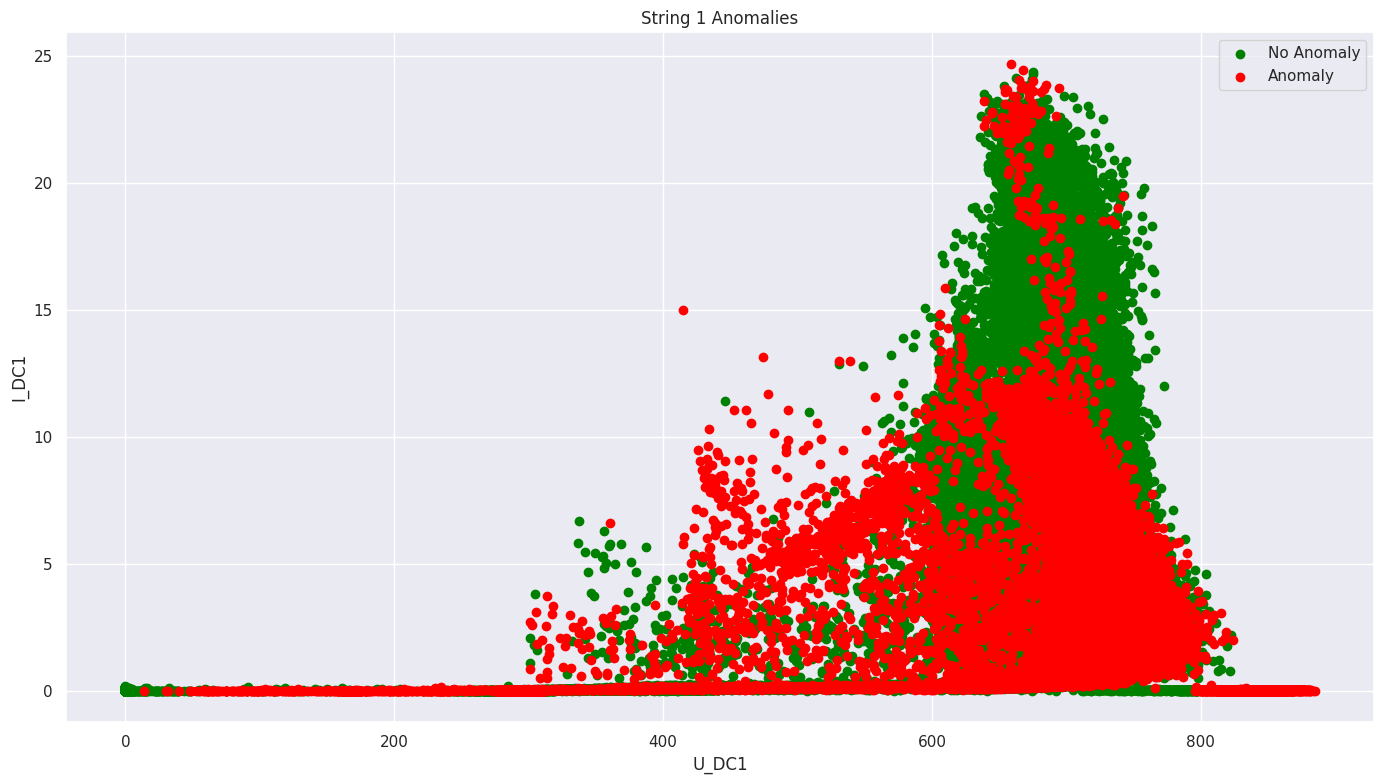

In [31]:
#STRING1

# Gráfico 1
plt.figure(figsize=(14, 8))

# Gráfico 1
plt.scatter(no_anomaly['U_DC1'], no_anomaly['I_DC1'], label='No Anomaly',color='green')
plt.scatter(anomaly['U_DC1'], anomaly['I_DC1'], label='Anomaly',color='red')
plt.xlabel('U_DC1')
plt.ylabel('I_DC1')
plt.legend()
plt.title('String 1 Anomalies')


# Ajustes de diseño
plt.tight_layout()
plt.show()

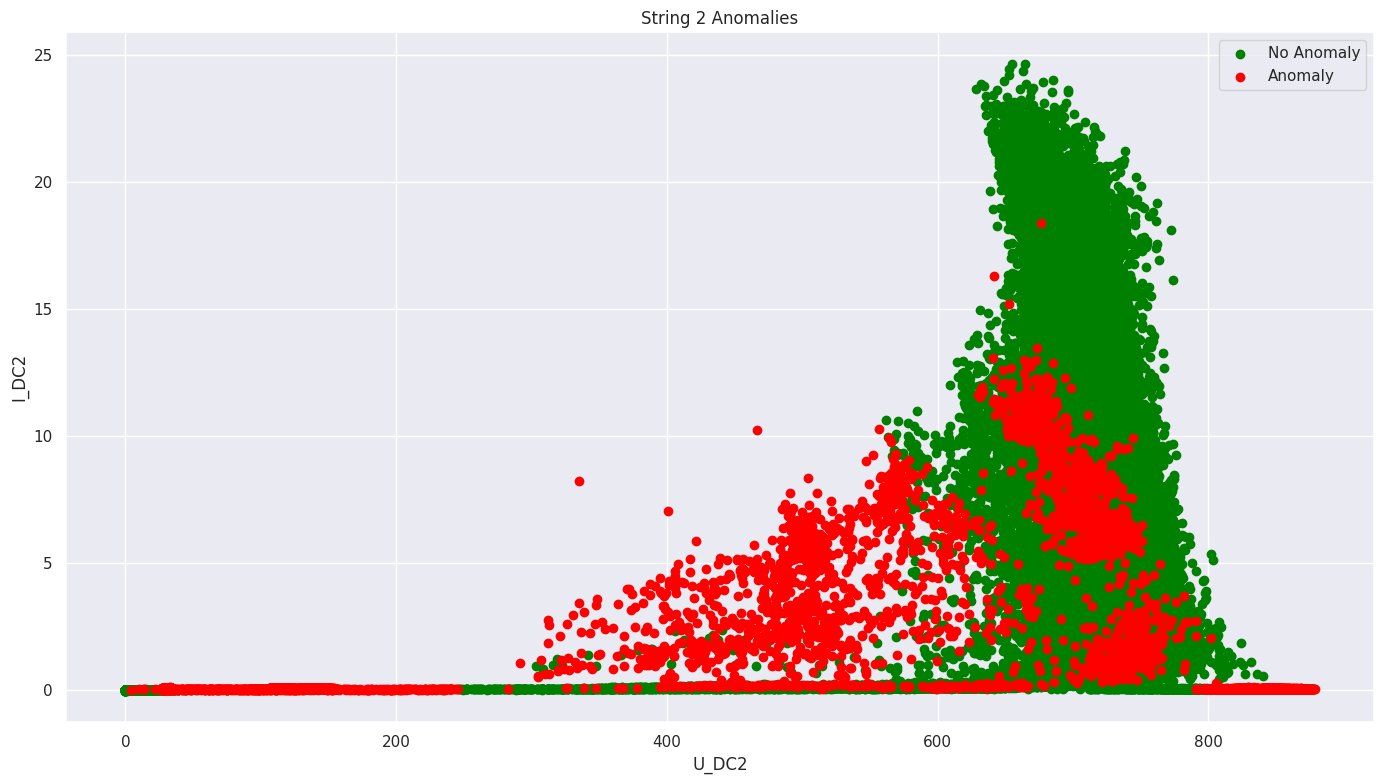

In [32]:
#STRING2

# Gráfico 1
plt.figure(figsize=(14, 8))

# Gráfico 1
plt.scatter(no_anomaly['U_DC2'], no_anomaly['I_DC2'], label='No Anomaly',color='green')
plt.scatter(anomaly['U_DC2'], anomaly['I_DC2'], label='Anomaly',color='red')
plt.xlabel('U_DC2')
plt.ylabel('I_DC2')
plt.legend()
plt.title('String 2 Anomalies')


# Ajustes de diseño
plt.tight_layout()
plt.show()